# Bayesian Bivariate Model

In [1]:
import sys

sys.path.append("../../")

import matplotlib.pyplot as plt
import pandas as pd

import penaltyblog as pb

## Get data from football-data.co.uk

In [2]:
df = pd.concat(
    [
        # pb.scrapers.FootballData("ENG Premier League", "2017-2018").get_fixtures(),
        # pb.scrapers.FootballData("ENG Premier League", "2018-2019").get_fixtures(),
        # pb.scrapers.FootballData("ENG Premier League", "2019-2020").get_fixtures(),
        pb.scrapers.FootballData("ENG Premier League", "2020-2021").get_fixtures(),
        pb.scrapers.FootballData("ENG Premier League", "2021-2022").get_fixtures(),
    ]
)

df

,date,datetime,season,competition,div,time,team_home,team_away,fthg,ftag,...,b365_cahh,b365_caha,pcahh,pcaha,max_cahh,max_caha,avg_cahh,avg_caha,goals_home,goals_away
id,,,,,,,,,,,,,,,,,,,,,
1599868800---crystal_palace---southampton,2020-09-12,2020-09-12 15:00:00,2020-2021,ENG Premier League,E0,15:00,Crystal Palace,Southampton,1,0,...,1.78,2.13,1.79,2.17,1.85,2.18,1.79,2.12,1,0
1599868800---fulham---arsenal,2020-09-12,2020-09-12 12:30:00,2020-2021,ENG Premier League,E0,12:30,Fulham,Arsenal,0,3,...,2.01,1.89,2.02,1.91,2.13,1.92,2.02,1.87,0,3
1599868800---liverpool---leeds,2020-09-12,2020-09-12 17:30:00,2020-2021,ENG Premier League,E0,17:30,Liverpool,Leeds,4,3,...,1.85,2.05,1.85,2.08,1.90,2.16,1.84,2.04,4,3
1599868800---west_ham---newcastle,2020-09-12,2020-09-12 20:00:00,2020-2021,ENG Premier League,E0,20:00,West Ham,Newcastle,0,2,...,2.03,1.87,2.04,1.88,2.09,1.91,2.02,1.86,0,2
1599955200---tottenham---everton,2020-09-13,2020-09-13 16:30:00,2020-2021,ENG Premier League,E0,16:30,Tottenham,Everton,0,1,...,2.09,1.81,2.09,1.85,2.16,1.86,2.08,1.81,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653177600---crystal_palace---man_united,2022-05-22,2022-05-22 16:00:00,2021-2022,ENG Premier League,E0,16:00,Crystal Palace,Man United,1,0,...,1.68,2.15,1.74,2.23,1.88,2.25,1.74,2.16,1,0
1653177600---leicester---southampton,2022-05-22,2022-05-22 16:00:00,2021-2022,ENG Premier League,E0,16:00,Leicester,Southampton,4,1,...,1.83,2.07,1.88,2.03,1.94,2.26,1.87,2.01,4,1
1653177600---liverpool---wolves,2022-05-22,2022-05-22 16:00:00,2021-2022,ENG Premier League,E0,16:00,Liverpool,Wolves,3,1,...,2.02,1.77,2.06,1.83,2.19,1.99,2.07,1.80,3,1


In [14]:
# def logic(ctx):
#     fixture = ctx.fixture
#     account = ctx.account

#     if 3.0 <= fixture["b365_a"] <= 4.0:
#         account.place_bet(
#             fixture["b365_a"],
#             account.current_bankroll * 0.03,
#             1 if ctx.fixture["ftr"] == "A" else 0,
#         )


def trainer(ctx):
    weights = pb.models.dixon_coles_weights(ctx.lookback["date"], 0.001)

    model = pb.models.DixonColesGoalModel(
        teams_home=ctx.lookback["team_home"],
        teams_away=ctx.lookback["team_away"],
        goals_home=ctx.lookback["goals_home"],
        goals_away=ctx.lookback["goals_away"],
        weights=weights,
    )

    model.fit()

    return model


def logic(ctx):
    fixture = ctx.fixture
    account = ctx.account
    model = ctx.model

    pred = model.predict(fixture["team_home"], fixture["team_away"])

    kc = pb.kelly.criterion(fixture["b365_h"], pred.home_win)
    if kc > 0:
        account.place_bet(
            fixture["b365_h"],
            account.current_bankroll * kc,
            1 if ctx.fixture["ftr"] == "H" else 0,
        )
        
    kc = pb.kelly.criterion(fixture["b365_a"], pred.away_win)
    if kc > 0:
        account.place_bet(
            fixture["b365_a"],
            account.current_bankroll * kc,
            1 if ctx.fixture["ftr"] == "A" else 0,
        )        
        
    kc = pb.kelly.criterion(fixture["b365_d"], pred.draw)
    if kc > 0:
        account.place_bet(
            fixture["b365_d"],
            account.current_bankroll * kc,
            1 if ctx.fixture["ftr"] == "D" else 0,
        )          

In [15]:
backtest = pb.backtest.Backtest(df, "2022-04-01", "2022-06-01", True)
backtest.start(100, logic, trainer)
backtest.results()

  0%|          | 0/29 [00:00<?, ?it/s]

{'Total Bets': 95,
 'Successful Bets': 29,
 'Successful Bet %': 30.526315789473685,
 'Max Bankroll': 135.09670489466157,
 'Profit': -73.76749653837545,
 'ROI': -73.76749653837545}

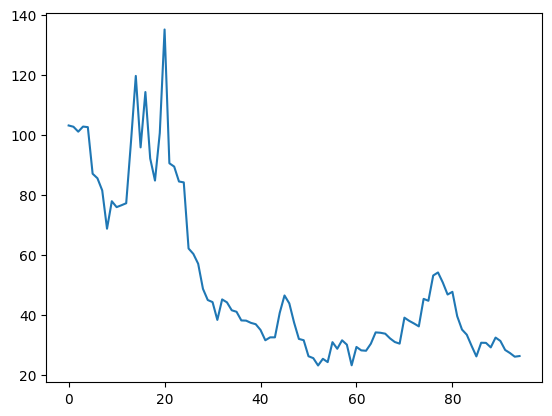

In [16]:
plt.plot(backtest.account.tracker)

In [ ]:
df.iloc[0].to_dict()